# **Problem Statement**

This assignment is about feature extraction via dimensionality reduction using variants of autoencoders.  Use the CIFAR10 dataset provided in Keras, after conversion to gray-level images!

Task 1: Perform standard PCA and identify the eigenvectors associated with top eigenvalues with 95% total energy (i,e.,  >=95 percent). Using these, train a logistic regression classifier to classify the images into 10 classes. Draw the ROC curve for the test dataset. Repeat the same with randomized PCA and compare.

Task 2: Train a single layer autoencoder with linear activation function and appropriate normalization of the input. Compare the eigenvectors obtained in step 1 with those obtained using the autoencoders. Explain your observations.

Task 3: Train an appropriate deep convolutional autoencoder with same dimension of latent space. Calculate the reconstruction error and compare that with a single hidden layer autoencoder (with sigmoid activation at the autoencoder and linear at the decoder) for the test dataset. What will be the reconstruction error if the hidden nodes are distributed equally (approximately) among 3 hidden layers in a new 3 hidden layer autoencoder with sigmoid activation at the autoencoder and linear at the decoder final layer.

# **Code as follows**:

# Requirements Installation:


In [1]:
!pip install numpy
!pip install tensorflow
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

# Importing Neccessary libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from time import time

# Data Preprocessing

In [3]:
def load_and_preprocess_data():

    """
    Load CIFAR10 dataset, convert to grayscale, and preprocess.
    """

    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

    X_train_gray = np.mean(X_train, axis=3, keepdims=True).astype('float32') / 255.0
    X_test_gray = np.mean(X_test, axis=3, keepdims=True).astype('float32') / 255.0

    X_train_gray_flat = X_train_gray.reshape(X_train.shape[0], -1)
    X_test_gray_flat = X_test_gray.reshape(X_test.shape[0], -1)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_gray_flat)
    X_test_scaled = scaler.transform(X_test_gray_flat)

    return X_train_gray, X_test_gray, X_train_scaled, X_test_scaled, y_train, y_test


# Task 1: PCA and Logistic Regression Module Components:

In [4]:
def perform_pca(X_train, X_test, n_components, pca_type='standard'):

    """
    Perform PCA (standard or randomized) on the data.
    """

    if pca_type == 'standard':
        pca = PCA(n_components=n_components, svd_solver='full')
    else:
        pca = PCA(n_components=n_components, svd_solver='randomized', random_state=42)

    start_time = time()
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    end_time = time()

    return X_train_pca, X_test_pca, pca.n_components_, pca.components_, pca.explained_variance_ratio_, end_time - start_time

def train_and_evaluate(X_train_pca, X_test_pca, y_train, y_test):
    """
    Train a logistic regression classifier and evaluate its performance.
    """

    clf = LogisticRegression(multi_class='ovr', max_iter=1000)
    clf.fit(X_train_pca, y_train.ravel())

    y_score = clf.predict_proba(X_test_pca)
    y_pred = clf.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)

    return y_score, accuracy

def compute_roc_curves(y_test, y_score):
    """
    Compute ROC curves for multi-class classification.
    """
    y_test_bin = label_binarize(y_test, classes=range(10))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return fpr, tpr, roc_auc

def plot_roc_curves(fpr, tpr, roc_auc, title):

    """
    Plot ROC curves for multi-class classification.
    """

    plt.figure(figsize=(10, 8))
    for i in range(10):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def get_n_components_for_variance(X, variance_threshold=0.95):
    """
    Calculate n components for variance of PCA
    """
    pca = PCA(n_components=variance_threshold, svd_solver='full')
    pca.fit(X)
    return pca.n_components_

# Task 2: Single Layer Autoencoder Module Components:

In [5]:
def build_and_train_single_layer_autoencoder_linear(X_train, X_test, encoding_dim, t2_epochs, t2_batch_size):
    """
    Build and train a single layer autoencoder with linear activation.
    """

    input_dim = X_train.shape[1]

    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='linear', use_bias=False)(input_layer)
    decoded = Dense(input_dim, activation='linear', use_bias=False)(encoded)

    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)

    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    history = autoencoder.fit(X_train, X_train,
                              epochs=t2_epochs,
                              batch_size=t2_batch_size,
                              shuffle=True,
                              validation_data=(X_test, X_test),
                              verbose=1)

    return encoder, history


def compare_eigenvectors(pca_eigenvectors, autoencoder_weights, n_components_to_plot=10, showcase="Standard"):

    """
    Compare PCA eigenvectors with autoencoder weights visually.
    """

    n_components = min(n_components_to_plot, pca_eigenvectors.shape[0])

    fig, axes = plt.subplots(n_components, 2, figsize=(10, 5*n_components))
    fig.suptitle(f'PCA Eigenvectors {showcase} vs Autoencoder Weights', fontsize=16)

    for i in range(n_components):
        # PCA eigenvector
        axes[i, 0].imshow(pca_eigenvectors[i].reshape(32, 32), cmap='gray')
        axes[i, 0].set_title(f'PCA Eigenvector {i+1}')
        axes[i, 0].axis('off')

        # Autoencoder weight
        axes[i, 1].imshow(autoencoder_weights[:, i].reshape(32, 32), cmap='gray')
        axes[i, 1].set_title(f'Autoencoder Weight {i+1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


def calculate_similarity(pca_eigenvectors, autoencoder_weights):

    """
    Calculate similarity between PCA eigenvectors and autoencoder weights.
    """

    similarities = np.abs(np.dot(pca_eigenvectors, autoencoder_weights))
    return similarities


def cumulative_explained_variance(explained_variance_ratio, pca_flag):
    """
    Plots cumulative explained variance
    """
    cumulative_variance = np.cumsum(explained_variance_ratio)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title(f'Cumulative Explained Variance vs. Number of PCA Components {pca_flag}')
    plt.grid(True)
    plt.show()

def similarity_heatmap(similarities, pca_flag):
    """
    Plots similarity heatmap
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(similarities, cmap='hot', aspect='auto')
    plt.colorbar()
    plt.title(f'Similarity between PCA Eigenvectors {pca_flag} and Autoencoder Weights')
    plt.xlabel('Autoencoder Weight Index')
    plt.ylabel(f'PCA Eigenvector {pca_flag} Index')
    plt.show()

# Task 3: Convolutional and Deep Autoencoders Module Components:

In [6]:
def build_and_train_conv_autoencoder(X_train, X_test, encoding_dim, t3_epochs, t3_batch_size):
    """
    Build and train a convolutional autoencoder.
    """
    input_img = Input(shape=(32, 32, 1))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(encoding_dim, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(encoding_dim, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    history = autoencoder.fit(X_train, X_train,
                              epochs=t3_epochs,
                              batch_size=t3_batch_size,
                              shuffle=True,
                              validation_data=(X_test, X_test),
                              verbose=1)

    return autoencoder, history


def build_and_train_single_layer_autoencoder_sigmoid(X_train, X_test, encoding_dim, t3_epochs, t3_batch_size):
    """
    Build and train a single layer autoencoder with sigmoid activation.
    """
    input_dim = X_train.shape[1] * X_train.shape[2]* X_train.shape[3]

    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='sigmoid')(input_layer)
    decoded = Dense(input_dim, activation='linear')(encoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    X_train_flat = X_train.reshape((X_train.shape[0], -1))
    X_test_flat = X_test.reshape((X_test.shape[0], -1))

    history = autoencoder.fit(X_train_flat, X_train_flat,
                              epochs=t3_epochs,
                              batch_size=t3_batch_size,
                              shuffle=True,
                              validation_data=(X_test_flat, X_test_flat),
                              verbose=1)

    return autoencoder, history


def build_and_train_deep_autoencoder(X_train, X_test, encoding_dim, t3_epochs, t3_batch_size):
    """
    Build and train a deep autoencoder with 3 hidden layers.
    """
    input_dim = X_train.shape[1] * X_train.shape[2]* X_train.shape[3]
    hidden_dim1 = encoding_dim * 3 // 2
    hidden_dim2 = encoding_dim

    input_layer = Input(shape=(input_dim,))
    encoded = Dense(hidden_dim1, activation='sigmoid')(input_layer)
    encoded = Dense(hidden_dim2, activation='sigmoid')(encoded)
    decoded = Dense(hidden_dim1, activation='sigmoid')(encoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    X_train_flat = X_train.reshape((X_train.shape[0], -1))
    X_test_flat = X_test.reshape((X_test.shape[0], -1))

    history = autoencoder.fit(X_train_flat, X_train_flat,
                              epochs=t3_epochs,
                              batch_size=t3_batch_size,
                              shuffle=True,
                              validation_data=(X_test_flat, X_test_flat),
                              verbose=1)

    return autoencoder, history


def calculate_reconstruction_error(autoencoder, X_test):
    """
    Calculate reconstruction error for autoencoder.
    """

    if len(autoencoder.input_shape) == 4:  # Convolutional autoencoder
        X_test_reshaped = X_test
    else:  # Dense autoencoder
        X_test_reshaped = X_test.reshape((X_test.shape[0], -1))

    X_test_pred = autoencoder.predict(X_test_reshaped)

    # Ensure X_test_reshaped and X_test_pred have same shape
    assert X_test_reshaped.shape == X_test_pred.shape, "Shapes don't match"

    mse = np.mean(np.square(X_test_reshaped - X_test_pred))
    return mse

def plot_training_history(history, title):
    """
    Plot training history for autoencoders.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()


def visualize_reconstructions(original, conv_recon, single_recon, deep_recon):
    """
    Visualize original and reconstructed images from different autoencoders.
    """
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Original vs Reconstructed Images', fontsize=16)

    for i in range(4):
        axes[0, i].imshow(original[i].reshape(32, 32), cmap='gray')
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')

    axes[1, 0].imshow(conv_recon[0].reshape(32, 32), cmap='gray')
    axes[1, 0].set_title('Conv Autoencoder')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(single_recon[0].reshape(32, 32), cmap='gray')
    axes[1, 1].set_title('Single Layer')
    axes[1, 1].axis('off')

    axes[1, 2].imshow(deep_recon[0].reshape(32, 32), cmap='gray')
    axes[1, 2].set_title('Deep Autoencoder')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()


def count_parameters(model):
    """
    Count the number of trainable parameters in a model.
    """
    return sum(p.numpy().size for p in model.trainable_weights)

#Main execution


 Loading and preprocessing CIFAR10 dataset
170498071/170498071 [==============================] - 6s 0us/step

 Completed Loadig and preprocessing of CIFAR10 dataset

------------------------------------Task 1: PCA and Logistic Regression---------------------------------------------------

	Number of components for 95% variance: 161


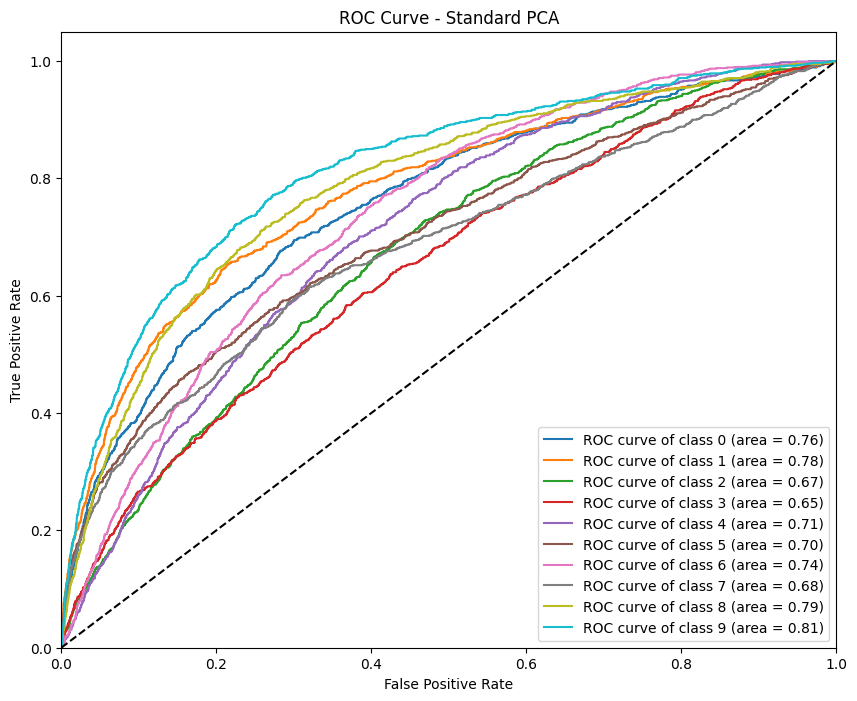

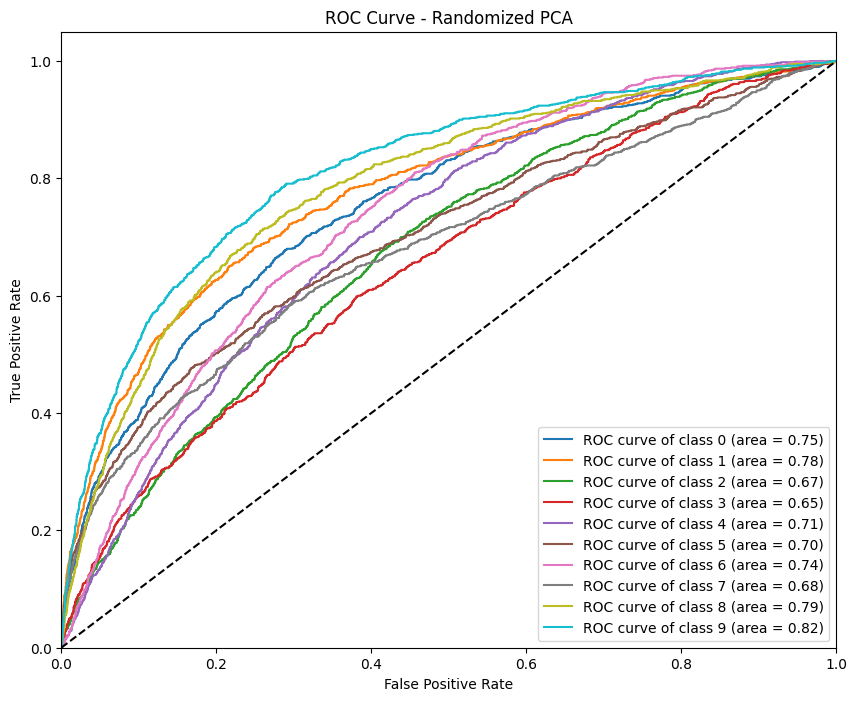


	Standard PCA - Components: 161, Time: 9.37s, Accuracy: 0.3145

	Randomized PCA - Components: 161, Time: 4.08s, Accuracy: 0.3118


--------------------------------------------Task 2: Single Layer Autoencoder--------------------------------------------

	Training Single Layer Autoencoder for epochs and batch_size: 30, 256
Epoch 1/30
196/196 [==============================] - 3s 6ms/step - loss: 0.2745 - val_loss: 0.1274
Epoch 2/30
196/196 [==============================] - 1s 5ms/step - loss: 0.1012 - val_loss: 0.0837
Epoch 3/30
196/196 [==============================] - 1s 5ms/step - loss: 0.0745 - val_loss: 0.0676
Epoch 4/30
196/196 [==============================] - 1s 5ms/step - loss: 0.0634 - val_loss: 0.0606
Epoch 5/30
196/196 [==============================] - 1s 5ms/step - loss: 0.0581 - val_loss: 0.0566
Epoch 6/30
196/196 [==============================] - 1s 4ms/step - loss: 0.0554 - val_loss: 0.0547
Epoch 7/30
196/196 [==============================] - 1s 4ms/step - loss: 0.

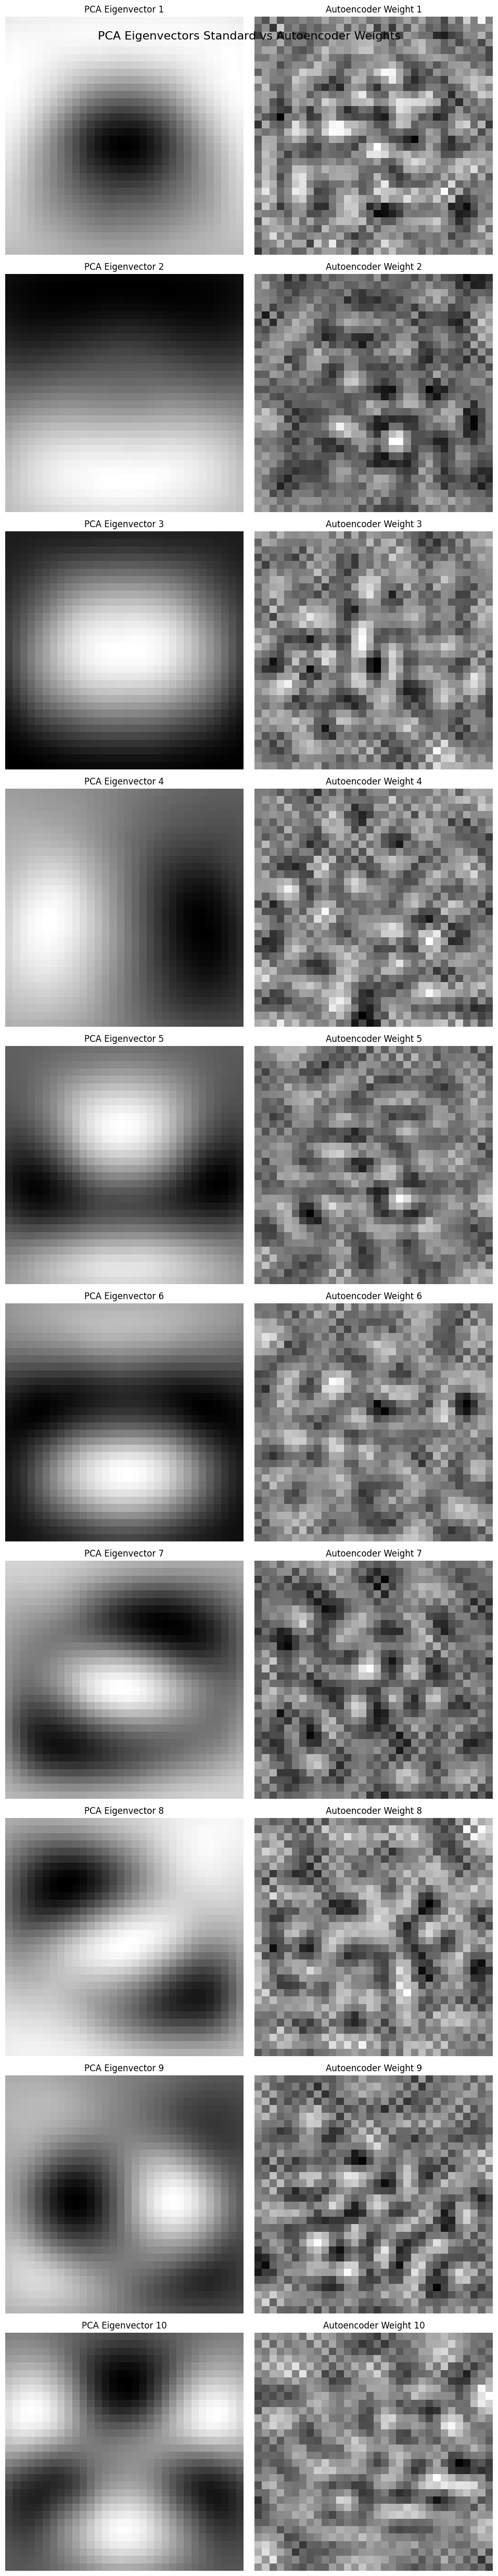

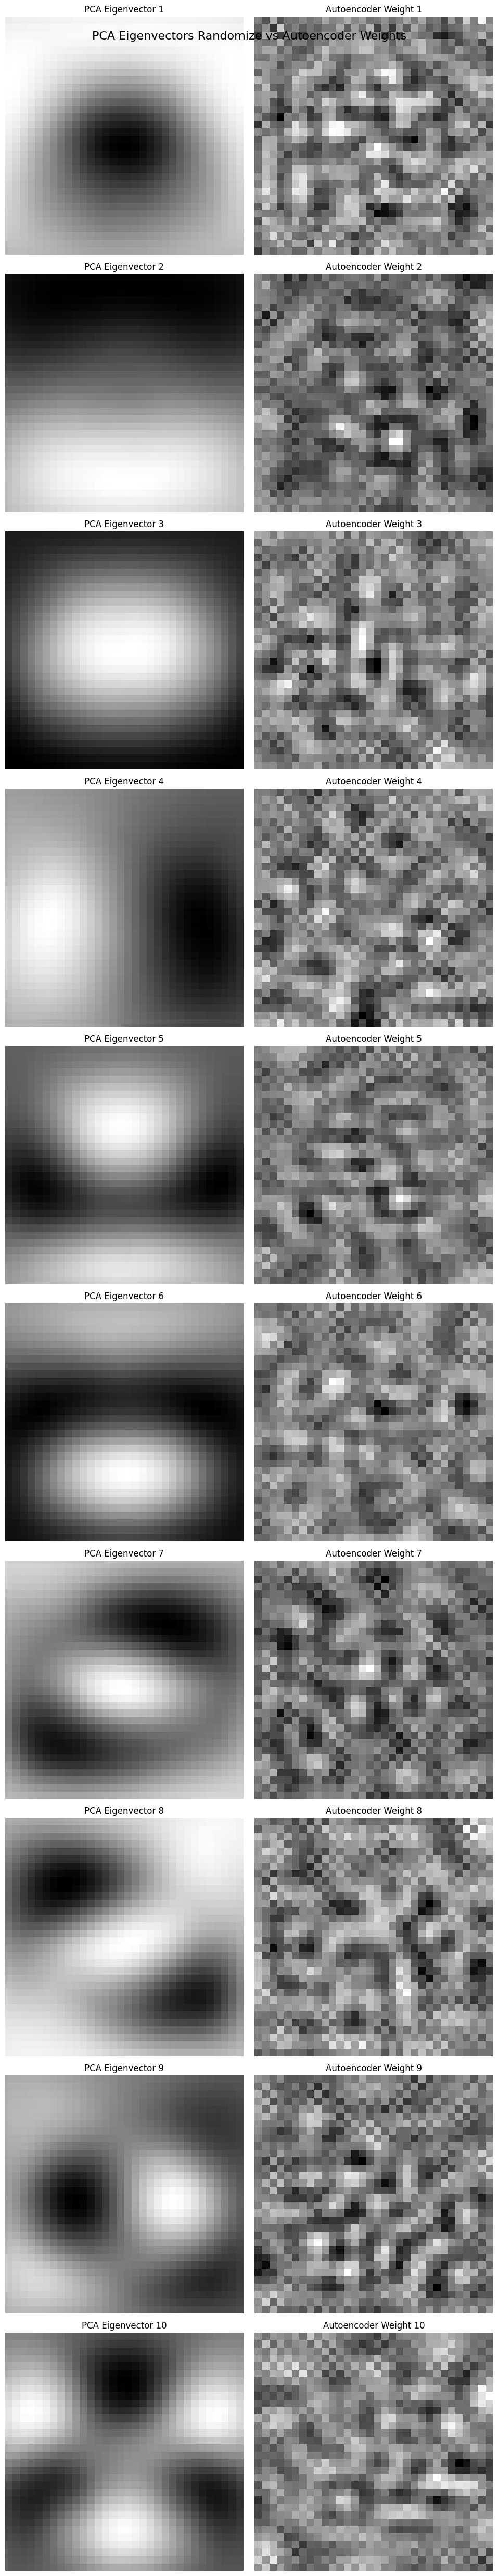

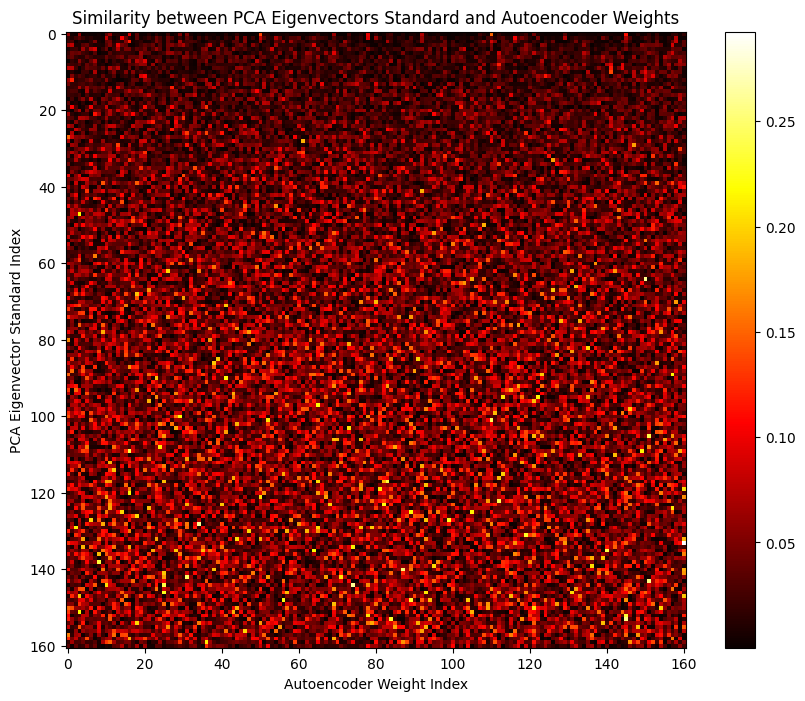

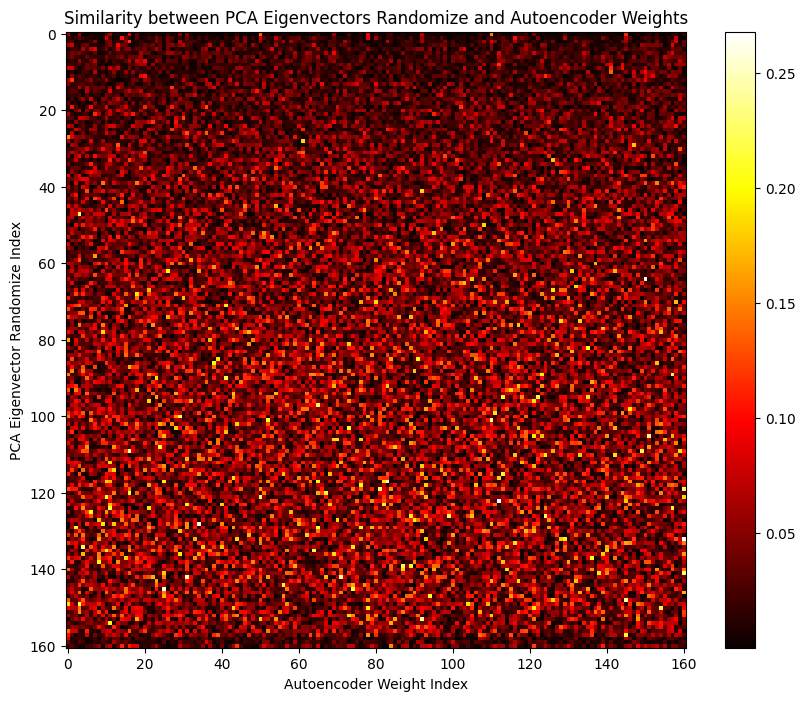

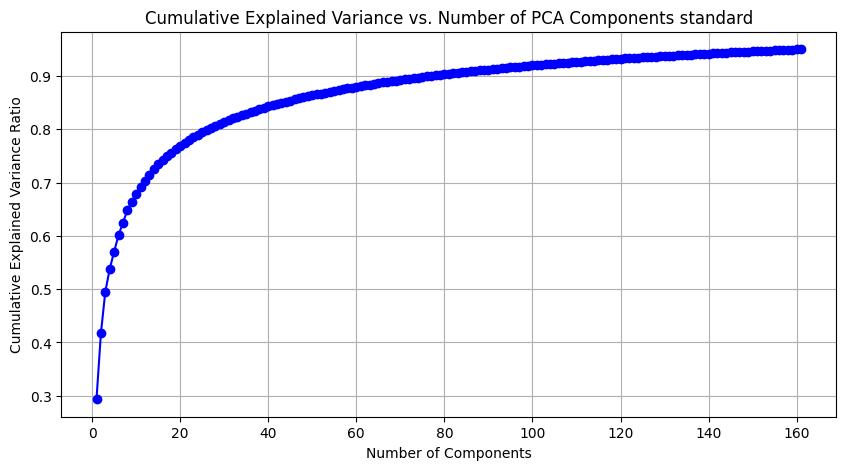

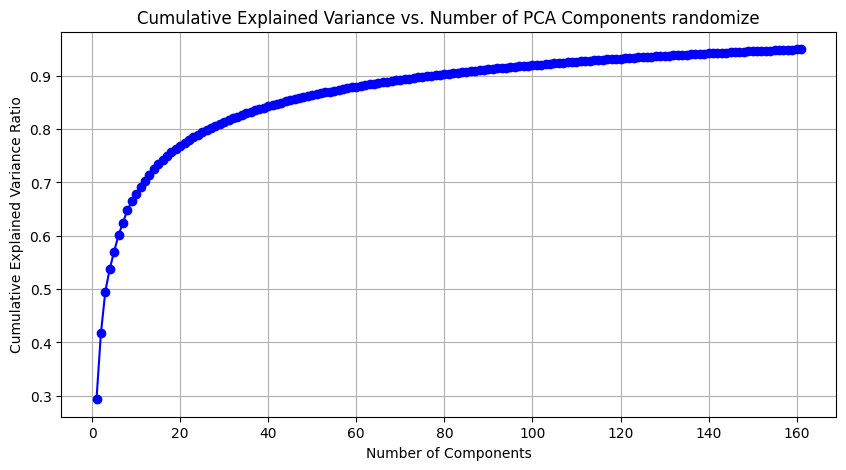

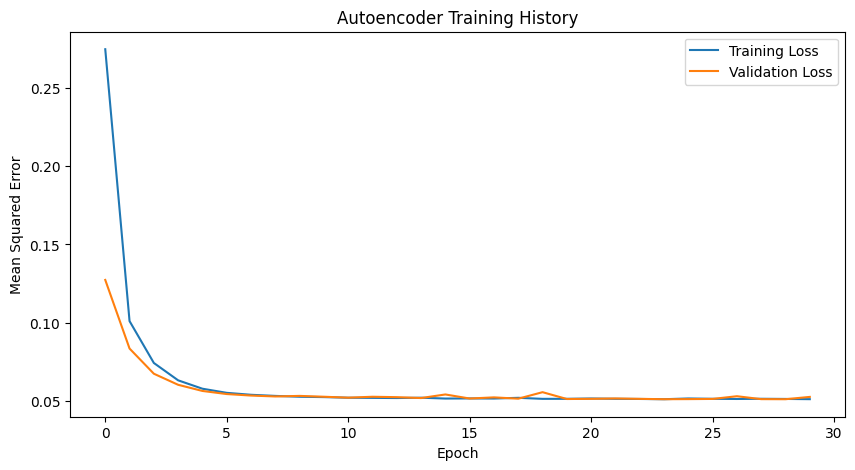



------------------------------------------Task 3: Convolutional and Deep Autoencoders-----------------------------------

	Training Convolutional Autoencoder for epochs and batch_size: 30, 256
Epoch 1/30
196/196 [==============================] - 11s 28ms/step - loss: 0.0173 - val_loss: 0.0099
Epoch 2/30
196/196 [==============================] - 4s 19ms/step - loss: 0.0091 - val_loss: 0.0080
Epoch 3/30
196/196 [==============================] - 4s 20ms/step - loss: 0.0077 - val_loss: 0.0082
Epoch 4/30
196/196 [==============================] - 4s 21ms/step - loss: 0.0066 - val_loss: 0.0059
Epoch 5/30
196/196 [==============================] - 4s 19ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 6/30
196/196 [==============================] - 4s 20ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 7/30
196/196 [==============================] - 4s 21ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 8/30
196/196 [==============================] - 4s 20ms/step - loss: 0.0047 - val_loss: 0.0

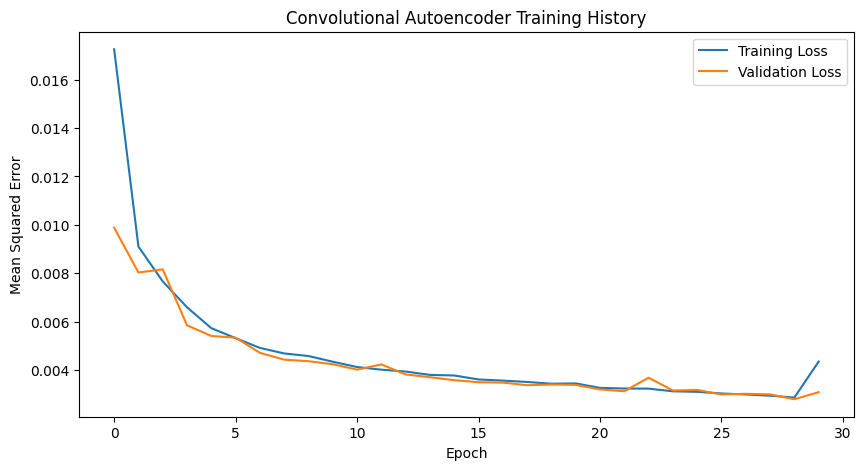

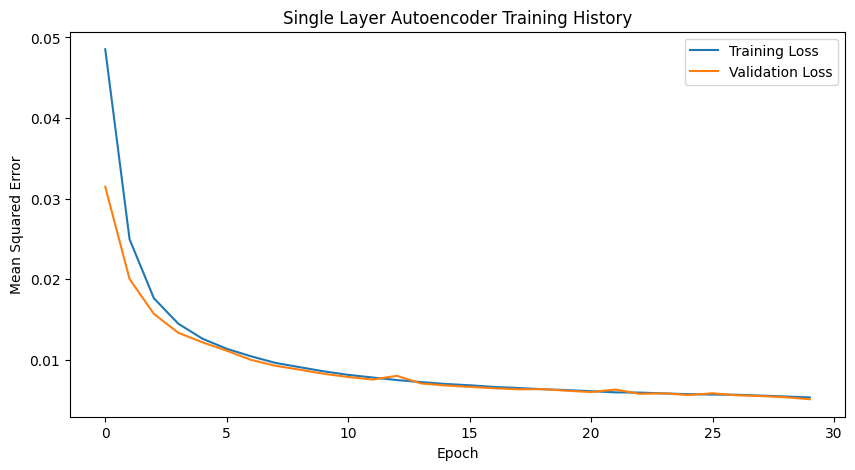

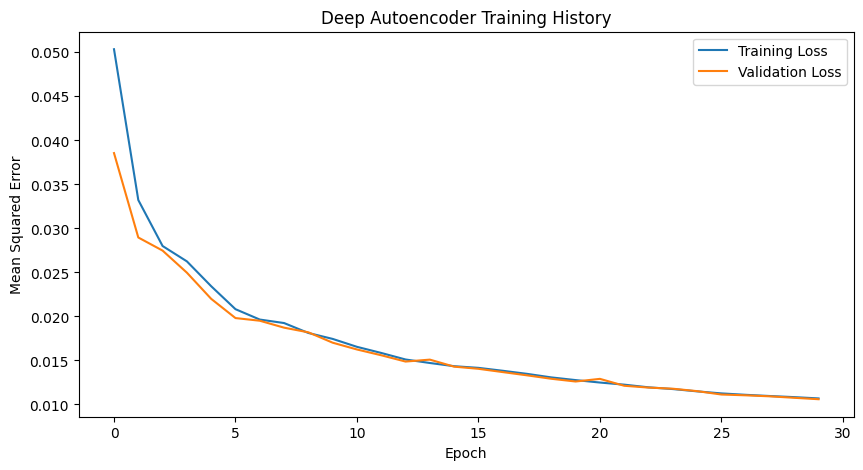

313/313 [==============================] - 1s 2ms/step

Reconstruction Errors:
	Convolutional Autoencoder: 0.0031
	Single Layer Autoencoder: 0.0051
	Deep Autoencoder: 0.0106

Computation Time (seconds):
	Convolutional Autoencoder: 126.39
	Single Layer Autoencoder: 42.51
	Deep Autoencoder: 34.91

Model Complexity (number of parameters):
	Convolutional Autoencoder: 456716
	Single Layer Autoencoder: 330913
	Deep Autoencoder: 572837

Visualize Reconstructions:


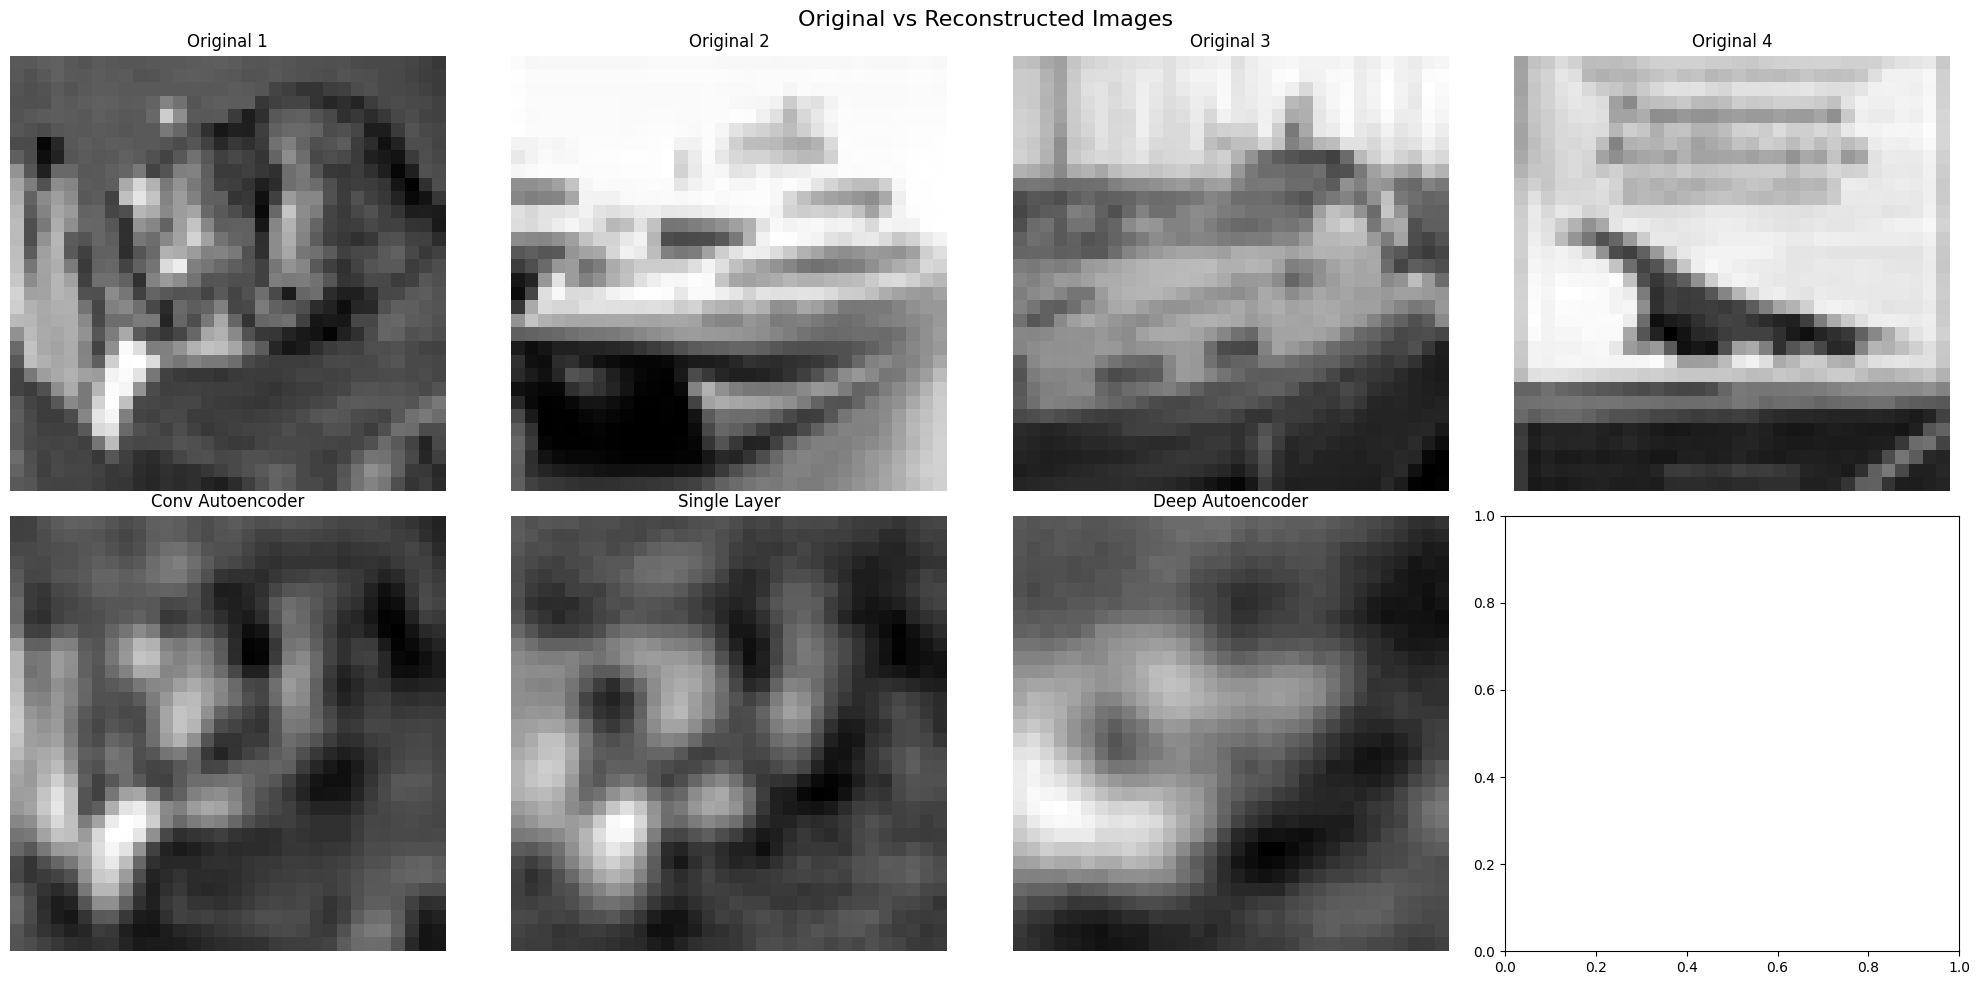

In [7]:
def main():
    # Load and preprocess data
    print(f"\n Loading and preprocessing CIFAR10 dataset")
    X_train_gray, X_test_gray, X_train_scaled, X_test_scaled, y_train, y_test = load_and_preprocess_data()
    print(f"\n Completed Loadig and preprocessing of CIFAR10 dataset")

    # Task 1: PCA and Logistic Regression
    print("\n------------------------------------Task 1: PCA and Logistic Regression---------------------------------------------------")

    # Determine number of components for 95% variance
    n_components = get_n_components_for_variance(X_train_scaled)
    print(f"\n\tNumber of components for 95% variance: {n_components}")

    # Perform standard PCA
    X_train_pca_std, X_test_pca_std, pca_n_components_std, pca_eigenvectors_std, explained_variance_ratio_std ,time_std = perform_pca(X_train_scaled, X_test_scaled, n_components, 'standard')

    # Train and evaluate with standard PCA
    y_score_std, accuracy_std = train_and_evaluate(X_train_pca_std, X_test_pca_std, y_train, y_test)

    # Compute and plot ROC curves for standard PCA
    fpr_std, tpr_std, roc_auc_std = compute_roc_curves(y_test, y_score_std)
    plot_roc_curves(fpr_std, tpr_std, roc_auc_std, 'ROC Curve - Standard PCA')

    # Perform randomized PCA
    X_train_pca_rand, X_test_pca_rand, pca_n_components_rand, pca_eigenvectors_rand, explained_variance_ratio_rand, time_rand = perform_pca(X_train_scaled, X_test_scaled, n_components, 'randomized')

    # Train and evaluate with randomized PCA
    y_score_rand, accuracy_rand = train_and_evaluate(X_train_pca_rand, X_test_pca_rand, y_train, y_test)

    # Compute and plot ROC curves for randomized PCA
    fpr_rand, tpr_rand, roc_auc_rand = compute_roc_curves(y_test, y_score_rand)
    plot_roc_curves(fpr_rand, tpr_rand, roc_auc_rand, 'ROC Curve - Randomized PCA')

    # Print comparison results
    print(f"\n\tStandard PCA - Components: {pca_n_components_std}, Time: {time_std:.2f}s, Accuracy: {accuracy_std:.4f}")
    print(f"\n\tRandomized PCA - Components: {pca_n_components_rand}, Time: {time_rand:.2f}s, Accuracy: {accuracy_rand:.4f}")


# Task 2: Single Layer Autoencoder
    print("\n\n--------------------------------------------Task 2: Single Layer Autoencoder--------------------------------------------")

    t2_epochs = 30
    t2_batch_size = 256

    # Build and train autoencoder
    print(f"\n\tTraining Single Layer Autoencoder for epochs and batch_size: {t2_epochs}, {t2_batch_size}")

    start_time = time()
    encoder, history = build_and_train_single_layer_autoencoder_linear(X_train_scaled, X_test_scaled, n_components, t2_epochs, t2_batch_size)
    t2_time = time() - start_time

    print("\n\tComputation Time (seconds):")
    print(f"\t\tT2 Single Layer autoencoder: {t2_time:.2f}")

    # Get autoencoder weights
    autoencoder_weights = encoder.get_weights()[0]

    # Compare eigenvectors
    compare_eigenvectors(pca_eigenvectors_std, autoencoder_weights, showcase="Standard")
    print("\n\n")
    compare_eigenvectors(pca_eigenvectors_rand, autoencoder_weights, showcase="Randomize")
    print("\n\n")

    # Calculate similarity between PCA eigenvectors and autoencoder weights
    similarities_std = calculate_similarity(pca_eigenvectors_std, autoencoder_weights)
    similarities_rand = calculate_similarity(pca_eigenvectors_rand, autoencoder_weights)

    # Plot similarity heatmap
    similarity_heatmap(similarities_std, pca_flag = 'Standard')
    similarity_heatmap(similarities_rand, pca_flag = 'Randomize')

    # Plot cumulative explained variance
    cumulative_explained_variance(explained_variance_ratio_std, pca_flag = 'standard')
    cumulative_explained_variance(explained_variance_ratio_rand, pca_flag = 'randomize')

    # Plot training history
    plot_training_history(history, 'Autoencoder Training History')


# Task 3: Convolutional and Deep Autoencoders
    print("\n\n------------------------------------------Task 3: Convolutional and Deep Autoencoders-----------------------------------")

    t3_epochs = 30
    t3_batch_size = 256

    # Build and train autoencoder
    print(f"\n\tTraining Convolutional Autoencoder for epochs and batch_size: {t3_epochs}, {t3_batch_size}")

    # Train convolutional autoencoder
    start_time = time()
    conv_autoencoder, conv_history = build_and_train_conv_autoencoder(X_train_gray, X_test_gray, n_components, t3_epochs, t3_batch_size)
    conv_time = time() - start_time

    print("\n\n")
    print(f"\n\tTraining Single Layer Autoencoder for epochs and batch_size: {t3_epochs}, {t3_batch_size}")
    # Train single layer autoencoder
    start_time = time()
    single_layer_autoencoder, single_layer_history = build_and_train_single_layer_autoencoder_sigmoid(X_train_gray, X_test_gray, n_components, t3_epochs, t3_batch_size)
    single_layer_time = time() - start_time

    print("\n\n")
    print(f"\n\tTraining Deep Autoencoder for epochs and batch_size: {t3_epochs}, {t3_batch_size}")
    # Train deep autoencoder with 3 hidden layers
    start_time = time()
    deep_autoencoder, deep_history = build_and_train_deep_autoencoder(X_train_gray, X_test_gray, n_components, t3_epochs, t3_batch_size)
    deep_time = time() - start_time

    # Plot training histories
    plot_training_history(conv_history, 'Convolutional Autoencoder Training History')
    plot_training_history(single_layer_history, 'Single Layer Autoencoder Training History')
    plot_training_history(deep_history, 'Deep Autoencoder Training History')

    # Calculate reconstruction errors
    conv_reconstruction_error = calculate_reconstruction_error(conv_autoencoder, X_test_gray)
    single_layer_reconstruction_error = calculate_reconstruction_error(single_layer_autoencoder, X_test_gray)
    deep_reconstruction_error = calculate_reconstruction_error(deep_autoencoder, X_test_gray)

    X_test_flat = X_test_gray.reshape((X_test_gray.shape[0], -1))
    conv_recon = conv_autoencoder.predict(X_test_gray)
    single_recon = single_layer_autoencoder.predict(X_test_flat)
    deep_recon = deep_autoencoder.predict(X_test_flat)

    # Print results
    print("\nReconstruction Errors:")
    print(f"\tConvolutional Autoencoder: {conv_reconstruction_error:.4f}")
    print(f"\tSingle Layer Autoencoder: {single_layer_reconstruction_error:.4f}")
    print(f"\tDeep Autoencoder: {deep_reconstruction_error:.4f}")

    print("\nComputation Time (seconds):")
    print(f"\tConvolutional Autoencoder: {conv_time:.2f}")
    print(f"\tSingle Layer Autoencoder: {single_layer_time:.2f}")
    print(f"\tDeep Autoencoder: {deep_time:.2f}")

    print("\nModel Complexity (number of parameters):")
    print(f"\tConvolutional Autoencoder: {count_parameters(conv_autoencoder)}")
    print(f"\tSingle Layer Autoencoder: {count_parameters(single_layer_autoencoder)}")
    print(f"\tDeep Autoencoder: {count_parameters(deep_autoencoder)}")

    print("\nVisualize Reconstructions:")

    # Visualize reconstructions
    visualize_reconstructions(X_test_gray[:4], conv_recon[:4], single_recon[:4], deep_recon[:4])

if __name__ == "__main__":
    main()


# Observations:

**Task 1: PCA and Logistic Regression**
1. The number of components needed for 95% variance was determined, providing insight into the intrinsic dimensionality of the data.
2. Both standard and randomized PCA were performed, allowing for a comparison between these two approaches.
3. ROC curves were plotted for both standard and randomized PCA, showing the classification performance across different classes.
4. The accuracy and computation time for both PCA methods were compared:
  * Standard PCA: Components: 161, Time: 9.37s, Accuracy: 0.3145
  * Randomized PCA: Components: 161, Time: 4.08s, Accuracy: 0.3118
5. This comparison allows for understanding the trade-off between performance and computational efficiency of the two PCA methods.

**Task 2: Single Layer Autoencoder**
1. Trained single layer autoencoder with linear activation for 30 epochs, batch size 256.
2. Computation time: 43.69
 seconds.
2. The autoencoder weights may not be in the same order as PCA eigenvectorsa and it might have different signs compared to PCA eigenvectors.
4. Similarity heatmaps quantify correspondence between autoencoder weights and PCA eigenvectors.
5. Cumulative explained variance plots show shows how many components are needed for a certain amount of variance.
6. Autoencoder training history shows how the model learns over time.

**Task 3: Convolutional and Deep Autoencoders**
1. Compared three autoencoder architectures (convolutional, single layer with sigmoid, deep) trained for 30 epochs, batch size 256.
2. Reconstruction Errors:
  * Convolutional: 0.0031
  * Single Layer: 0.0051
  * Deep: 0.0106
3. Computation Times:
  * Convolutional: 126.39s
  * Single Layer: 42.51s
  * Deep: 34.91s
4. Model Complexity (parameters):
  * Convolutional: 456716
  * Single Layer: 330913
  * Deep: 572837
5. Reconstructed images were visualized for qualitative performance comparison.
